In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
from hess.nets import Transformer
from hess.nets import LSTM

In [2]:
nx = 500
test_x = torch.linspace(0, 10, nx).unsqueeze(-1).unsqueeze(-1)
test_y = torch.sin(test_x * 0.5) + torch.sin(test_x)

In [3]:
splts = [i * nx//5 for i in range(1, 6)]

In [4]:
splts

[100, 200, 300, 400, 500]

In [5]:
train_x = torch.cat((test_x[:splts[0], :], 
                     test_x[splts[1]:splts[2], :], 
                     test_x[splts[3]:splts[4], :]))
train_y = torch.cat((test_y[:splts[0], :], 
                     test_y[splts[1]:splts[2], :], 
                     test_y[splts[3]:splts[4], :]))

In [6]:
# plt.plot(test_x, test_y)
# plt.scatter(train_x, train_y)

In [7]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(6)
    train_x, train_y = train_x.cuda(), train_y.cuda()

In [8]:
optimus = Transformer(train_x, train_y, 
                      net=LSTM,
                      n_hidden=2, hidden_size=10)

In [9]:
print(sum(p.numel() for p in optimus.net.parameters()))

1411


In [10]:
if use_cuda:
    optimus = optimus.cuda()

In [11]:
optimus.train_net(print_loss=True, lr=0.01, iters=10,
                 loss_func=torch.nn.MSELoss())

tensor(0.9273, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.8756, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.8255, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.7757, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.7240, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.6677, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.6005, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.5139, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.4149, device='cuda:6', grad_fn=<MseLossBackward>)
tensor(0.3262, device='cuda:6', grad_fn=<MseLossBackward>)


In [12]:
out = optimus(train_x)

In [13]:
out.shape

torch.Size([300, 1, 1])

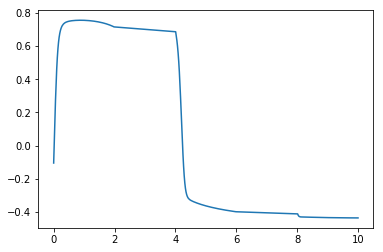

In [14]:
plt.plot(train_x.squeeze().cpu(), out.squeeze().detach().cpu())

## Let's get this bread

In [15]:
import hess.utils as utils

In [16]:
model = optimus.net
par_list = model.parameters()
n_par_w_bias = sum(torch.numel(p) for p in par_list)

In [17]:
n_par_w_bias

1411

In [18]:
optimus.net.train()

LSTM(
  (lstm): LSTM(1, 10, num_layers=2)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [19]:
e1 = torch.zeros(n_par_w_bias)
e1[0] = 1
e1 = e1.unsqueeze(0)

In [20]:
magic_e1 = utils.unflatten_like(e1, model.parameters())

device(type='cpu')

In [21]:
utils.eval_hess_vec_prod(magic_e1, model.parameters(), 
                         net=optimus.net,
                         criterion=torch.nn.MSELoss(), 
                         inputs=train_x, targets=train_y)

RuntimeError: expected device cuda:6 but got device cpu

In [ ]:
output = utils.gradtensor_to_tensor(optimus.net, include_bn=True)

In [ ]:
output.nelement()

In [ ]:
optimus.net.train()

In [ ]:
base_vec = torch.zeros(n_par_w_bias).cuda().unsqueeze(0)
base_vec[0, 0] = 1.

base_vec = utils.unflatten_like(base_vec, model.parameters())
utils.eval_hess_vec_prod(base_vec, model.parameters(),
                        net=optimus.net,
                        criterion=torch.nn.MSELoss(),
                        inputs=train_x, targets=train_y)
output = utils.gradtensor_to_tensor(optimus.net)

n_par = output.nelement()

In [ ]:
hessian = torch.zeros(n_par, n_par)
for pp in range(n_par):
    base_vec = torch.zeros(n_par_w_bias).cuda().unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model.parameters(),
                            net=optimus.net,
                            criterion=torch.nn.MSELoss(),
                            inputs=train_x, targets=train_y)
    if pp == 0:
        output = utils.gradtensor_to_tensor(optimus.net)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    hessian[:, pp] = utils.gradtensor_to_tensor(optimus.net)

In [ ]:
eigs_out = hessian.eig(eigenvectors=True)

In [ ]:
evals = eigs_out[0][:, 0]

In [ ]:
plt.plot(evals.abs().log().sort()[0].cpu())

## Save model to use on laptop

In [ ]:
torch.save(optimus.net.state_dict(), "../hess/saved-models/lstm_regression.pt")

In [ ]:
torch.save(hessian, "../hess/saved-models/lstm_hessian.pt")